<a href="https://colab.research.google.com/github/jaden-2/Assignment/blob/master/seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


[Problem 1] Execution of machine translation and code reading

In [1]:
!wget http://www.manythings.org/anki/fra-eng.zip

--2024-07-24 23:07:09--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7943074 (7.6M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   7.57M  3.89MB/s    in 1.9s    

2024-07-24 23:07:11 (3.89 MB/s) - ‘fra-eng.zip’ saved [7943074/7943074]



In [2]:
!unzip fra-eng.zip

Archive:  fra-eng.zip
  inflating: _about.txt              
  inflating: fra.txt                 


In [3]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text, _ = line.split('\t')
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    encoder_input_data[i, t + 1:, input_token_index[' ']] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.
    decoder_input_data[i, t + 1:, target_token_index[' ']] = 1.
    decoder_target_data[i, t:, target_token_index[' ']] = 1.
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['accuracy'])
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# Save model
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 91
Max sequence length for inputs: 14
Max sequence length for outputs: 59
Epoch 1/100
125/125 [==============================] - 9s 29ms/step - loss: 1.2131 - accuracy: 0.7332 - val_loss: 1.1012 - val_accuracy: 0.6999
Epoch 2/100
125/125 [==============================] - 2s 15ms/step - loss: 0.9331 - accuracy: 0.7493 - val_loss: 0.9688 - val_accuracy: 0.7254
Epoch 3/100
125/125 [==============================] - 2s 14ms/step - loss: 0.8390 - accuracy: 0.7683 - val_loss: 0.8926 - val_accuracy: 0.7457
Epoch 4/100
125/125 [==============================] - 2s 13ms/step - loss: 0.7407 - accuracy: 0.7915 - val_loss: 0.7842 - val_accuracy: 0.7747
Epoch 5/100
125/125 [==============================] - 2s 15ms/step - loss: 0.6687 - accuracy: 0.8082 - val_loss: 0.7321 - val_accuracy: 0.7868
Epoch 6/100
125/125 [==============================] - 2s 16ms/step - loss: 0.6274 - accuracy: 0.8178 - val_loss: 0

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 17ms/step
-
Input sentence: Go.
Decoded sentence: Conge !

1/1 [==============================] - 0s 20ms/step
-
Input sentence: Go.
Decoded sentence: Conge !

1/1 [==============================] - 0s 19ms/step
-
Input sentence: Go.
Decoded sentence: Conge !

1/1 [==============================] - 0s 20ms/step
-
Input sentence: Go.
Decoded sentence: Conge !

1/1 [==============================] - 0s 18ms/step
-
Input sentence: Hi.
Decoded sentence: Salut.

1/1 [==============================] - 0s 27ms/step
-
Input sentence: Hi.
Decoded sentence: Salut.

1/1 [==============================] - 0s 30ms/step
-
Input sentence: Run!
Decoded sentence: Filez !

1/1 [==============================] - 0s 30ms/step
-
Input sentence: Run!
Decoded sentence: Filez !

1/1 [==============================] - 0s 20ms/step
-
Input sentence: Run!
Decoded sentence: Filez !

1/1 [==============================] - 0s 26ms/step
-
Input sentence: Run!
Decoded sentenc

51-55: Importing the libraries
57-61: Hyperparamaters initialization
62-83: Data vectorization, the data is loaded and splitted into lines and the texts are extracted
84-95: The input and target characters are created and the tokens are created by the length of the characters and the max sequence length are created
99-126: Create a table corresponding to the encoder input and decoder input/output.
127-143: Define a model that converts encoder_input_data and decoder_input_data to decoder_target_data, compile, train before saving. LSTM is used in both the encoder and decoder parts plus Dense for the decoder.
147-157: Definition of the model, training and saving. Lines 168-179: Define of the sampling models The encoder and decoder models are defined.
183-186: Reverse-lookup token index to decode sequences back to something readable.
189-224: decode_sequence function for decoding a given inputed sequence.
227-234: Showing results of a decoded sequence based on the inputed sequence.


[Problem 2] Execution of a trained model of image captioning

In [6]:
!git clone https://github.com/yunjey/pytorch-tutorial.git

fatal: destination path 'pytorch-tutorial' already exists and is not an empty directory.


In [7]:
%cd pytorch-tutorial/tutorials/03-advanced/image_captioning/

/content/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [8]:
!wget https://www.dropbox.com/scl/fi/5pbpnmdqarpl3im03e6sk/pretrained_model.zip?rlkey=t60qk1iyys5fejbbwgvx5p5hq&e=3&st=vv8068q6&dl=0

--2024-07-24 23:12:57--  https://www.dropbox.com/scl/fi/5pbpnmdqarpl3im03e6sk/pretrained_model.zip?rlkey=t60qk1iyys5fejbbwgvx5p5hq
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd28a842a64e3a9f066c2e6240d.dl.dropboxusercontent.com/cd/0/inline/CXUaUq-nWGE_miFiBP8fhtnUcDiPQ_Vc8xTUFvhp77XYYKBBeq3d8jQYqNVt6P4W6pYg8pC9GaE4jMkHyGvNkAvjjMVgY10rfASGy7S3kPOnqVl8G9-AuItPqkaJVp8kVSVYH5D928rHKeXP7LQ-iQ6-/file# [following]
--2024-07-24 23:12:58--  https://ucd28a842a64e3a9f066c2e6240d.dl.dropboxusercontent.com/cd/0/inline/CXUaUq-nWGE_miFiBP8fhtnUcDiPQ_Vc8xTUFvhp77XYYKBBeq3d8jQYqNVt6P4W6pYg8pC9GaE4jMkHyGvNkAvjjMVgY10rfASGy7S3kPOnqVl8G9-AuItPqkaJVp8kVSVYH5D928rHKeXP7LQ-iQ6-/file
Resolving ucd28a842a64e3a9f066c2e6240d.dl.dropboxusercontent.com (ucd28a842a64e3a9f066c2e6240d.dl.dropboxusercontent.com)... 162.125.8

In [9]:
!mkdir models

mkdir: cannot create directory ‘models’: File exists


In [10]:
!unzip 'pretrained_model.zip?rlkey=t60qk1iyys5fejbbwgvx5p5hq' -d ./models

Archive:  pretrained_model.zip?rlkey=t60qk1iyys5fejbbwgvx5p5hq
replace ./models/encoder-5-3000.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [11]:
!wget https://www.dropbox.com/scl/fi/r7g8pbh36tmcpbyk0gabm/vocap.zip?rlkey=xl8bmroltgedbq7m7glk3i57z&e=2&st=i69ong5r&dl=0

--2024-07-24 23:13:24--  https://www.dropbox.com/scl/fi/r7g8pbh36tmcpbyk0gabm/vocap.zip?rlkey=xl8bmroltgedbq7m7glk3i57z
Resolving www.dropbox.com (www.dropbox.com)... 162.125.81.18, 2620:100:6031:18::a27d:5112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.81.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc09d320cd8bd9e665ca9cefaf44.dl.dropboxusercontent.com/cd/0/inline/CXUdyIgBPp4ZhsUI_UF2PzHyo8vGQ1smupVKYj9hVz1_DZUcBgkhrLXUe_8tIDvudjmdcDRSRxP7TYWobceUzT0YN9barWOAnGH7YyGAv5QvjJU2WvmebxM_BUrDCT7uKJj1y6gHnSgY9R1WVHv7zLbi/file# [following]
--2024-07-24 23:13:25--  https://uc09d320cd8bd9e665ca9cefaf44.dl.dropboxusercontent.com/cd/0/inline/CXUdyIgBPp4ZhsUI_UF2PzHyo8vGQ1smupVKYj9hVz1_DZUcBgkhrLXUe_8tIDvudjmdcDRSRxP7TYWobceUzT0YN9barWOAnGH7YyGAv5QvjJU2WvmebxM_BUrDCT7uKJj1y6gHnSgY9R1WVHv7zLbi/file
Resolving uc09d320cd8bd9e665ca9cefaf44.dl.dropboxusercontent.com (uc09d320cd8bd9e665ca9cefaf44.dl.dropboxusercontent.com)... 162.125.81.15, 2620:

In [12]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [13]:
!unzip vocap.zip?rlkey=xl8bmroltgedbq7m7glk3i57z -d data

Archive:  vocap.zip?rlkey=xl8bmroltgedbq7m7glk3i57z
replace data/vocab.pkl? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [12]:
!pip install -r requirements.txt

In [14]:
!pip install torchvision

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [15]:
!pip install pycocotools

In [16]:
import torch
import torchvision

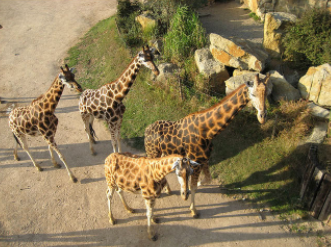

In [17]:
from IPython.display import Image,display_png
display_png(Image('png/example.png'))

In [19]:
!python sample.py --image="png/example.png"

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100% 230M/230M [00:17<00:00, 14.1MB/s]
<start> a group of giraffes standing next to each other . <end>


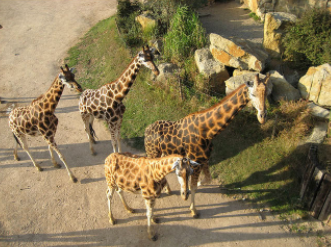

In [29]:
from PIL import Image
Image.open('example.png')

In [23]:
%cd png
!ls

/content/pytorch-tutorial/tutorials/03-advanced/image_captioning/png
example.png  image_captioning.png  model.png


In [32]:
%cd ..

/content/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [33]:
!python sample.py --image="png/example.png"

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
<start> a group of giraffes standing next to each other . <end>


[Problem 3] Investigate what to do if you want to move with Keras

You can use pytorch2keras converter that has been already built,
these are the steps provided in its readme
https://github.com/gmalivenko/pytorch2keras

1. You can convert by passing your model to pytorch_to_keras
2. It will return a keras model that you can save as an h5 file and then convert it with tensorflowjs_converter but it doesn't work sometimes. As alternative, you may get Tensorflow Graph and save it as a frozen model.
3. You will see the output layer name, so, now it's time to convert my_model.pb to tfjs model